# Model Monitoring for Cardiac Image Segmentation

In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-6a61a057-8a67-145d-6078-14f47ede1f86)


In [ ]:
import random
import numpy as np
import torch

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Install requirements

#### batchgenerators

In [ ]:
!pip install --upgrade batchgenerators

     |████████████████████████████████| 57 kB 3.7 MB/s 
     |████████████████████████████████| 96 kB 5.2 MB/s 
  Created wheel for batchgenerators: filename=batchgenerators-0.23-py3-none-any.whl size=84780 sha256=745b1bde4e31bc574706232b34a4fec30db6e5b6f56b0d56cdd518ea4c84d761
  Stored in directory: /root/.cache/pip/wheels/81/3d/a2/9a602ce56458c684d2962ec89eddd6bc06b00687735e2dd11a
Successfully built batchgenerators


#### medpy

In [ ]:
!pip install medpy

     |████████████████████████████████| 151 kB 7.5 MB/s 
     |████████████████████████████████| 48.4 MB 9.5 kB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp37-cp37m-linux_x86_64.whl size=754475 sha256=9e630da1024be5686b588bab11e23d8f4089a406baca70cc2804076f8002ec3a
  Stored in directory: /root/.cache/pip/wheels/b0/57/3a/da1183f22a6afb42e11138daa6a759de233fd977a984333602
Successfully built medpy


#### nibabel

In [ ]:
!pip install nibabel

## Import data

In [ ]:
!git clone https://github.com/manigalati/quality_control_CMR

Cloning into 'quality_control_CMR'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 141 (delta 80), reused 4 (delta 3), pack-reused 0
Receiving objects: 100% (141/141), 476.03 KiB | 11.07 MiB/s, done.
Resolving deltas: 100% (80/80), done.


In [ ]:
%cd /content/quality_control_CMR

/content/quality_control_CMR


In [ ]:
!mkdir data
#training set
!python gdrivedl.py https://drive.google.com/open?id=1bxRj0zf-iMooYA4jUZS_zS4VD9NLYxE4 data/
#testing set
!python gdrivedl.py https://drive.google.com/open?id=1L84oEmgc2Nd10bCBlaM7vkbl7nhrYC9I data/
#predictions
!python gdrivedl.py https://drive.google.com/open?id=1P2kNGllKUKmumaCM2IsqgIgRPAKEXa59 data/
#measures
!python gdrivedl.py https://drive.google.com/open?id=1ss-qGFEocJT-h3JAebcDjeWBQXcxPs0T data/

data/training.zip
[==================================================] 1554.02MB/1554.02MB
data/testing.zip
[==================================================] 762.27MB/762.27MB
data/predictions.zip
[==================================================] 3.75MB/3.75MB
data/measures.zip
[==================================================] 0.05MB/0.05MB


In [ ]:
!unzip -q data/training.zip -d data/

In [ ]:
!unzip -q data/testing.zip -d data/ 
!mv data/testing/testing data/tmp && rm -r data/testing && mv data/tmp data/testing

In [ ]:
!unzip -q data/predictions.zip -d data/

In [ ]:
!unzip -q data/measures.zip -d data/

## Data preparation

In [ ]:
import os
import numpy as np
from utils import generate_patient_info, preprocess

In [ ]:
patient_info = generate_patient_info("data/training/", patient_ids=range(1, 101))
patient_info = {**patient_info, **generate_patient_info("data/testing/", patient_ids=range(101, 151))}

if not os.path.exists("preprocessed/"):
    os.makedirs("preprocessed/")
np.save(os.path.join("preprocessed/", "patient_info"), patient_info)

In [ ]:
#spacings = [patient_info[id]["spacing"] for id in range(1, 101)]
#spacing_target = np.percentile(np.vstack(spacings), 50, 0)
spacing_target = [10, 1.25, 1.25]

if not os.path.exists("preprocessed/training/"):
    os.makedirs("preprocessed/training/")
preprocess(
    range(1,101), patient_info, spacing_target,
    "data/training", "preprocessed/training",
    lambda folder, id: os.path.join(folder, 'patient{:03d}'.format(id)),
    lambda patient_info, id, phase: "patient{:03d}_frame{:02d}_gt.nii.gz".format(id, patient_info[id][phase])
)

In [ ]:
for model in os.listdir("data/predictions/"):
    if not os.path.exists("preprocessed/predictions/{}".format(model)):
        os.makedirs("preprocessed/predictions/{}".format(model))
    preprocess(
        range(101,151), patient_info, spacing_target,
        "data/predictions/{}".format(model), "preprocessed/predictions/{}".format(model),
        lambda folder, id: folder,
        lambda patient_info, id, phase: "patient{:03d}_{}.nii.gz".format(id,phase)
    )

## Dataset

In [ ]:
import os
import numpy as np
import random
import torchvision
from utils import AddPadding, CenterCrop, OneHot, ToTensor, MirrorTransform, SpatialTransform

In [ ]:
ids = random.sample(range(1, 101), 100)
train_ids = ids[:80]
val_ids = ids[80:]

transform = torchvision.transforms.Compose([
    AddPadding((256,256)),
    CenterCrop((256,256)),
    OneHot(),
    ToTensor()
])
transform_augmentation = torchvision.transforms.Compose([
    MirrorTransform(),
    SpatialTransform(patch_size=(256,256), angle_x=(-np.pi/6,np.pi/6), scale=(0.7,1.4), random_crop=True),
    OneHot(),
    ToTensor()
])

## Training

In [ ]:
import torch

from CA import AE, plot_history, hyperparameter_tuning
from utils import ACDCDataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
parameters = {
    "BATCH_SIZE": [8, 4, 16],
    "DA": [True],
    "latent_size": [100, 500],
    "optimizer": [torch.optim.Adam],
    "lr": [2e-4, 1e-3, 1e-4],
    "weight_decay": [1e-5],
    "functions": [["GDLoss", "MSELoss", "BKMSELoss"], ["GDLoss"], ["BKGDLoss", "MSELoss"], ["BKGDLoss", "BKMSELoss"]],
    "settling_epochs": [2, 10],
    "tuning_epochs": [5, 10]
}

rules = [
    '"settling_epochs" == 0 or "BKGDLoss" in "functions" or "BKMSELoss" in "functions"',
    '"BKMSELoss" not in "functions" or "settling_epochs" < "tuning_epochs"'
]

optimal_parameters = hyperparameter_tuning(
    parameters,
    ACDCDataLoader("preprocessed/training", patient_ids=train_ids, batch_size=None, transform=None),
    ACDCDataLoader("preprocessed/training", patient_ids=val_ids, batch_size=None, transform=None),
    transform, transform_augmentation,
    rules,
    fast=True)

np.save(os.path.join("preprocessed/", "optimal_parameters"), optimal_parameters)

{'BATCH_SIZE': 8, 'DA': True, 'latent_size': 100, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.0002, 'weight_decay': 1e-05, 'functions': ['GDLoss', 'MSELoss', 'BKMSELoss'], 'settling_epochs': 2, 'tuning_epochs': 5}
Epoch [0]
GDLoss	MSELos	BKMSEL	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
-0.017	0.0151	0.0386	0.0363	0.9762	14.324	0.0000	nan	0.0000	nan	0.0000	nan	
Epoch [1]
GDLoss	MSELos	BKMSEL	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
-0.007	0.0143	0.0357	0.0420	0.9762	14.324	0.0000	nan	0.0000	nan	0.0000	nan	
Epoch [2]
GDLoss	MSELos	BKMSEL	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
-0.181	0.0111	0.0132	-0.157	0.9880	12.537	0.0076	43.994	0.1506	11.581	0.6230	10.922	
Epoch [3]
GDLoss	MSELos	BKMSEL	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
-0.246	0.0103	0.0122	-0.224	0.9893	12.055	0.0204	44.944	0.2184	10.893	0.6823	9.6373	
Epoch [4]
GDLoss	MSELos	BKMSEL	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
-0.312	0.0096	

Epoch [0]
MSELos	GDLoss	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
0.0217	0.0967	0.1184	0.9763	14.310	0.0000	nan	0.0000	nan	0.0000	nan	
Epoch [1]
MSELos	GDLoss	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
0.0213	0.0590	0.0803	0.9763	14.310	0.0000	nan	0.0000	nan	0.0000	nan	
Epoch [2]
MSELos	GDLoss	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
0.0187	0.0500	0.0687	0.9795	13.823	0.0023	nan	0.0302	nan	0.2291	nan	
Epoch [3]
MSELos	GDLoss	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
0.0138	0.0381	0.0519	0.9893	10.386	0.0521	30.065	0.3917	11.307	0.4650	13.170	
Epoch [4]
MSELos	GDLoss	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
0.0126	0.0319	0.0445	0.9903	9.8942	0.1917	26.320	0.3764	10.767	0.5814	9.2896	
Epoch [5]
MSELos	GDLoss	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
0.0107	0.0270	0.0378	0.9912	9.4305	0.3644	22.663	0.3216	10.490	0.7504	9.7484	
Epoch [6]
MSELos	GDLoss	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc

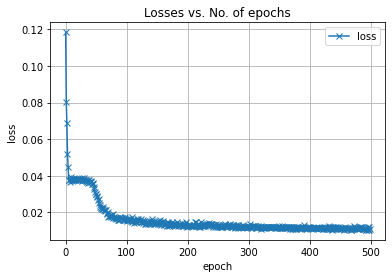

In [ ]:
optimal_parameters = np.load(os.path.join("preprocessed", "optimal_parameters.npy"), allow_pickle=True).item()

optimal_parameters = {
    "BATCH_SIZE": 8,
    "DA": False,
    "latent_size": 100,
    "optimizer": torch.optim.Adam,
    "lr": 2e-4,
    "weight_decay": 1e-5,
    "functions": ["BKGDLoss", "BKMSELoss"],
    "settling_epochs": 10
}

assert optimal_parameters is not None, "Be sure to continue with a working set of hyperparameters"

BATCH_SIZE = optimal_parameters["BATCH_SIZE"]
DA = optimal_parameters["DA"]

ae = AE(**optimal_parameters).to(device)

ckpt = None
if ckpt is not None:
    ckpt = torch.load(ckpt)
    ae.load_state_dict(ckpt["AE"])
    ae.optimizer.load_state_dict(ckpt["AE_optim"])
    start = ckpt["epoch"]+1
else:
    start = 0

print(ae)

plot_history(
    ae.training_routine(
        range(start, 500),
        ACDCDataLoader("preprocessed/training", patient_ids=train_ids, batch_size=BATCH_SIZE, transform=transform_augmentation if DA else transform),
        ACDCDataLoader("preprocessed/training", patient_ids=val_ids, batch_size=BATCH_SIZE, transform=transform),
        "checkpoints/"
    )
)

## Testing

In [ ]:
import os
import numpy as np
import torch
import nibabel as nib
from CA import AE
from utils import testing, display_image, display_difference, process_results, display_plots, ACDCDataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
optimal_parameters = np.load(os.path.join("preprocessed", "optimal_parameters.npy"), allow_pickle=True).item()
assert optimal_parameters is not None, "Be sure to continue with a working set of hyperparameters"

ckpt = os.path.join("checkpoints", sorted([file for file in os.listdir("checkpoints") if "_best" in file])[-1])
ckpt = torch.load(ckpt)

ae = AE(**optimal_parameters).to(device)
ae.load_state_dict(ckpt["AE"])
ae.optimizer.load_state_dict(ckpt["AE_optim"])
ae.eval();

In [ ]:
patient_info = np.load("preprocessed/patient_info.npy", allow_pickle=True).item()
#spacings = [patient_info[id]["spacing"] for id in range(1, 101)]
#current_spacing = np.percentile(np.vstack(spacings), 50, 0)
current_spacing = [10, 1.25, 1.25]

In [ ]:
test_loaders = {}
for model in os.listdir("preprocessed/predictions/"):
    test_loaders[model] = ACDCDataLoader("preprocessed/predictions/{}".format(model), patient_ids=range(101, 151), batch_size=BATCH_SIZE, transform=transform)

if not os.path.exists("postprocessed/measures"):
    os.makedirs("postprocessed/measures")
for model in sorted(test_loaders.keys()):
    if not os.path.exists("postprocessed/predictions/{}".format(model)):
        os.makedirs("postprocessed/predictions/{}".format(model))
    results = testing(ae, test_loaders[model], patient_info, "data/predictions/{}".format(model), "postprocessed/predictions/{}".format(model), current_spacing)
    np.save("postprocessed/measures/{}_AE.npy".format(model), results)

### Single patient

In [ ]:
model = "Bai"
patient_id = 102
phase = "ED"

prediction = nib.load("data/predictions/{}/patient{:03d}_{}.nii.gz".format(model, patient_id, phase)).get_fdata().transpose(2, 1, 0)
reconstruction = nib.load("postprocessed/predictions/{}/patient{:03d}_{}.nii.gz".format(model, patient_id, phase)).get_fdata().transpose(2, 1, 0)

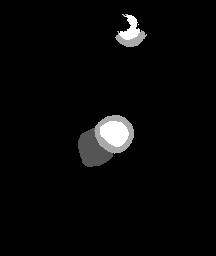

In [ ]:
from utils import display_image, display_difference
display_image(prediction[2])

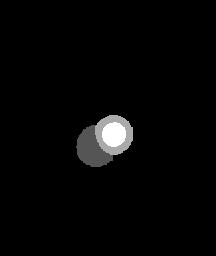

In [ ]:
display_image(reconstruction[2])

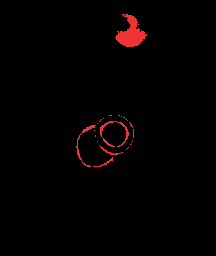

In [ ]:
display_difference(prediction[2],reconstruction[2])

### Plots

In [ ]:
models=["Bai","Baumgartner","Grinias","Isensee","Khened","Yang"]
plots=process_results(models,"data/measures/","postprocessed/measures/")

Anomalies (DSC=0/HD=nan): 16
Spotted by CA: 15
False Positive by CA: 0
Total discarded from the next plots: 16


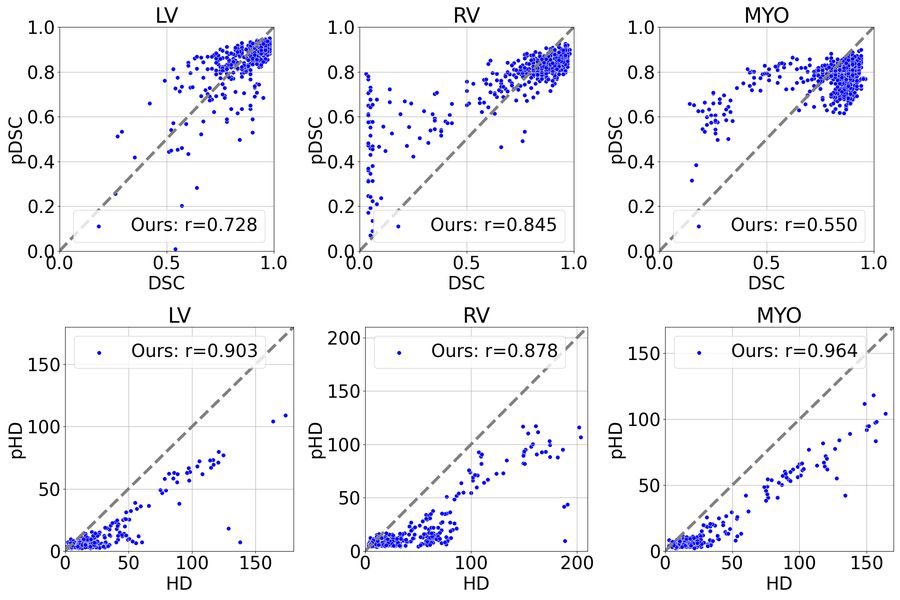

In [ ]:
display_plots(plots)